This is a project for detecting the action of falling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras import models
from keras import layers
from keras import metrics
from keras import optimizers
import keras
import numpy as np
import json
import os
import csv
import pandas as pd

# New Section

**Now we are cleaning all the data**

In [3]:
# now we read all the data
dataPath = "/content/drive/MyDrive/Colab Notebooks/data"

In [4]:
def readDataFrame(path, totalData, totalLabel):  
  total_df = pd.read_csv(path, header=None)
  label = total_df.iloc[:, 63]
  totalLabel += label.to_list()
  # now drop the label column
  total_df = total_df.drop(total_df.columns[63], axis = 1)
  for index, row in total_df.iterrows():
    totalData.append(row.to_list())
  return totalData, totalLabel

In [5]:
# now we read in all the data
Data = []
Label = []
for itemPath in os.listdir(dataPath):
  item = os.path.join(dataPath, itemPath)
  Data, Label = readDataFrame(item, Data, Label)


In [6]:
print("data length is " + str(len(Data)))
print("label length is " + str(len(Label)))

data length is 56268
label length is 56268


In [7]:
print("non falling label: " + str(Label.count(0)))
print("falling label: " + str(Label.count(1)))

non falling label: 53003
falling label: 3265


In [8]:
# now we need to up-sampling to balance the data
totalData = []
for i in range(len(Data)):
  totalData.append(Data[i])
  totalData[i].append(Label[i])    
df = pd.DataFrame.from_records(totalData)
df = df.rename(columns={df.columns[63]: "labels"})
fallDf = df[df['labels'] == 1]
nonFallDf = df[df['labels'] == 0]
from sklearn.utils import resample
sampled_fallDf = resample(fallDf, replace = True, n_samples=len(nonFallDf))
newData = pd.concat([nonFallDf, sampled_fallDf])
newData.labels.value_counts()

1    53003
0    53003
Name: labels, dtype: int64

In [22]:
# next we shuffle the data and split them
totalData = newData.values
np.random.shuffle(totalData)
test_data = totalData[: len(totalData) // 9]
train_data = totalData[len(totalData) // 9:]
print("train: " + str(len(train_data)))
print("test: " + str(len(test_data)))

train: 94228
test: 11778


In [23]:
# prepare all the training data and label
from keras.layers import LSTM
from keras import callbacks
from keras import layers
from keras.models import Sequential


train_x = []
train_y = []
for data in train_data:
  train_x.append(data[:63])
  train_y.append(int(data[63]))
train_x = np.array(train_x)
train_x = train_x.reshape((len(train_x), 1, len(train_x[0])))
train_y = np.array(train_y)

In [24]:
print(train_x.shape)
print(train_y.shape)

(94228, 1, 63)
(94228,)


In [25]:

# function for plotting the results
import matplotlib.pyplot as plt
def plotting_training(history):
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.show()
  # Plot training & validation loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label="Train loss")
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

In [31]:
# this is the dynamic learning rate function
def learningRate(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

In [32]:

# we start with GRU
model = Sequential()
model.add(layers.Conv1D(32, 1, activation='relu', input_shape=(1, 63)))
model.add(layers.MaxPool1D(1))
model.add(layers.Conv1D(32, 1, activation='relu'))
model.add(layers.GRU(32, dropout= 0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='acc', patience = 5), callbacks.LearningRateScheduler(learningRate)] )

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 1, 32)             2048      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 32)             1056      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 9,473
Trainable params: 9,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
4712/4712 [==============================] - 44s 9ms/step - loss: 0.5461 - acc: 0.7086 - val_loss: 0.3553 

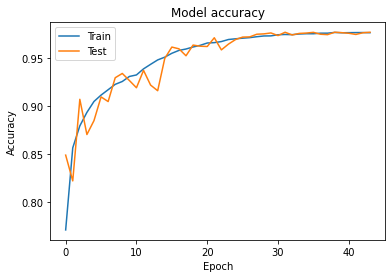

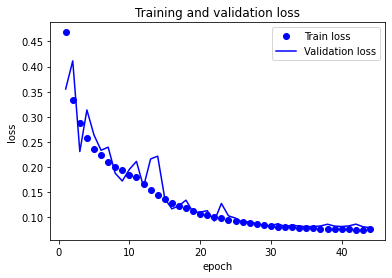

737/737 [==============================] - 2s 2ms/step - loss: 0.0846 - acc: 0.9752
test loss, test acc:  [0.08456606417894363, 0.975208044052124]


In [35]:
plotting_training(history)
test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 1, len(test_x[0])))
test_y = np.array(test_y)
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelGRU.h5")

In [ ]:

from keras.models import Sequential
from keras.layers import Embedding, Dense
model = Sequential()
model.add(LSTM(32, input_shape=(1, 63), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(learningRate)] )

Epoch 1/60
4712/4712 [==============================] - 54s 7ms/step - loss: 0.5733 - acc: 0.6818 - val_loss: 0.4415 - val_acc: 0.7959
Epoch 2/60
4712/4712 [==============================] - 35s 7ms/step - loss: 0.4019 - acc: 0.8171 - val_loss: 0.5146 - val_acc: 0.7611
Epoch 3/60
4712/4712 [==============================] - 36s 8ms/step - loss: 0.3486 - acc: 0.8502 - val_loss: 0.3384 - val_acc: 0.8627
Epoch 4/60
4712/4712 [==============================] - 34s 7ms/step - loss: 0.3130 - acc: 0.8687 - val_loss: 0.2943 - val_acc: 0.8780
Epoch 5/60
4712/4712 [==============================] - 35s 7ms/step - loss: 0.2863 - acc: 0.8806 - val_loss: 0.3750 - val_acc: 0.8135
Epoch 6/60
4712/4712 [==============================] - 35s 7ms/step - loss: 0.2603 - acc: 0.8924 - val_loss: 0.2280 - val_acc: 0.9137
Epoch 7/60
4712/4712 [==============================] - 35s 7ms/step - loss: 0.2405 - acc: 0.9027 - val_loss: 0.2377 - val_acc: 0.8947
Epoch 8/60
4712/4712 [==============================] -

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/projectModelLSTM.h5')

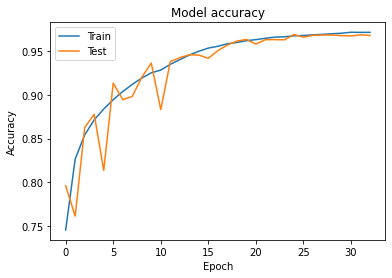

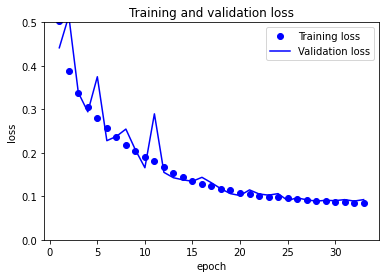

In [ ]:
plotting_training(history)

In [ ]:
test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 1, len(test_x[0])))
test_y = np.array(test_y)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)


737/737 [==============================] - 2s 3ms/step - loss: 0.0941 - acc: 0.9689
test loss, test acc:  [0.09414494782686234, 0.9689251184463501]


Epoch 1/60
4712/4712 [==============================] - 63s 12ms/step - loss: 0.5626 - acc: 0.6934 - val_loss: 0.4018 - val_acc: 0.8149
Epoch 2/60
4712/4712 [==============================] - 56s 12ms/step - loss: 0.3955 - acc: 0.8198 - val_loss: 0.3480 - val_acc: 0.8468
Epoch 3/60
4712/4712 [==============================] - 57s 12ms/step - loss: 0.3400 - acc: 0.8521 - val_loss: 0.3311 - val_acc: 0.8461
Epoch 4/60
4712/4712 [==============================] - 56s 12ms/step - loss: 0.3020 - acc: 0.8694 - val_loss: 0.2533 - val_acc: 0.8918
Epoch 5/60
4712/4712 [==============================] - 57s 12ms/step - loss: 0.2650 - acc: 0.8901 - val_loss: 0.2471 - val_acc: 0.8919
Epoch 6/60
4712/4712 [==============================] - 56s 12ms/step - loss: 0.2374 - acc: 0.9023 - val_loss: 0.1959 - val_acc: 0.9238
Epoch 7/60
4712/4712 [==============================] - 55s 12ms/step - loss: 0.2090 - acc: 0.9144 - val_loss: 0.1800 - val_acc: 0.9301
Epoch 8/60
4712/4712 [==========================

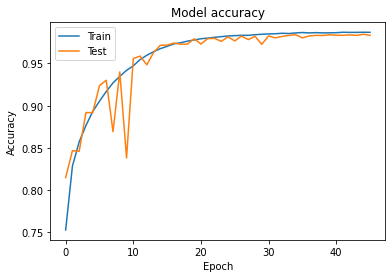

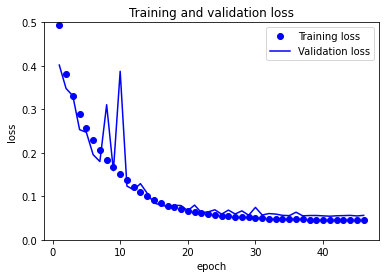

In [ ]:
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
# now we use the bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, 63)))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(scheduler)] )

plotting_training(history)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelBILSTM.h5")

737/737 [==============================] - 4s 5ms/step - loss: 0.0560 - acc: 0.9837
test loss, test acc:  [0.05598553270101547, 0.9836984276771545]


In [ ]:
# next we try the CNN
#create model
# we first reshape our data
train_x = []
train_y = []
for data in train_data:
  train_x.append(data[:63])
  train_y.append(int(data[63]))
train_x = np.array(train_x)
train_x = train_x.reshape((len(train_x), 3, int(len(train_x[0])/3), 1))
train_y = np.array(train_y)
print("shape of input data: ", train_x.shape)

test_x = []
test_y = []
for data in test_data:
  test_x.append(data[:63])
  test_y.append(int(data[63]))
test_x = np.array(test_x)
test_x = test_x.reshape((len(test_x), 3, int(len(test_x[0])/3), 1))
test_y = np.array(test_y)

shape of input data:  (94228, 3, 21, 1)


Epoch 1/60
4712/4712 [==============================] - 28s 6ms/step - loss: 0.4347 - acc: 0.8046 - val_loss: 0.1696 - val_acc: 0.9382
Epoch 2/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.1191 - acc: 0.9570 - val_loss: 0.0683 - val_acc: 0.9768
Epoch 3/60
4712/4712 [==============================] - 26s 5ms/step - loss: 0.0786 - acc: 0.9732 - val_loss: 0.0765 - val_acc: 0.9746
Epoch 4/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.0612 - acc: 0.9800 - val_loss: 0.0423 - val_acc: 0.9889
Epoch 5/60
4712/4712 [==============================] - 26s 6ms/step - loss: 0.0477 - acc: 0.9849 - val_loss: 0.0575 - val_acc: 0.9776
Epoch 6/60
4712/4712 [==============================] - 26s 6ms/step - loss: 0.0392 - acc: 0.9890 - val_loss: 0.0540 - val_acc: 0.9855
Epoch 7/60
4712/4712 [==============================] - 25s 5ms/step - loss: 0.0334 - acc: 0.9895 - val_loss: 0.0347 - val_acc: 0.9918
Epoch 8/60
4712/4712 [==============================] -

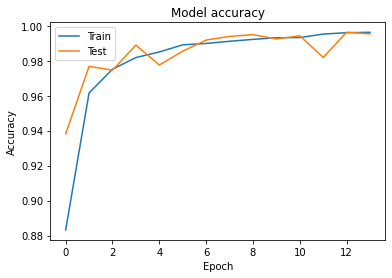

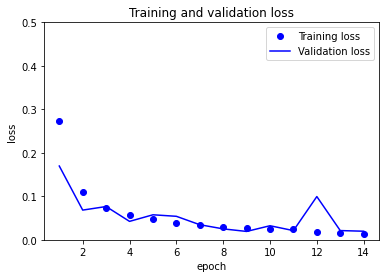

In [ ]:
model = Sequential()
model.add(layers.Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  input_shape=(3,21,1), 
                  padding='same'))
model.add(layers.BatchNormalization(1))
model.add(layers.Conv2D(64, 
                  kernel_size=3, 
                  activation='relu', 
                  padding='same'))
model.add(layers.BatchNormalization(1))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(Dense(512, activation = 'relu')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics = ['acc'])
history = model.fit(train_x, train_y, epochs= 60, batch_size = 16, validation_split = 0.2, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience = 5), callbacks.LearningRateScheduler(scheduler)] )
plotting_training(history)

In [ ]:
results = model.evaluate(test_x, test_y, batch_size = 16)
print("test loss, test acc: ", results)
model.save("/content/drive/MyDrive/Colab Notebooks/projectModelCNN.h5")

737/737 [==============================] - 2s 3ms/step - loss: 0.0225 - acc: 0.9943
test loss, test acc:  [0.022467508912086487, 0.9943114519119263]
